In [1]:
# ===================================================================
# === SCRIPT 1: FEATURE ENGINEERING FOR CLASSIFICATION ============
# ===================================================================

# === Imports ===
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofweek
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

# === Step 1: Create Spark Session ===
spark = SparkSession.builder.appName("FlightPulse-Classifier-Prep").getOrCreate()
print("--- SparkSession Created ---")


# === Step 2: Load and Prepare Base DataFrame ===
df = spark.read.csv("flights.csv", header=True, inferSchema=True)
df_transformed = df.withColumn(
    "flight_date_formatted", 
    to_date(col("FLIGHT_DATE"), "dd-MM-yyyy")
).withColumn(
    "day_of_week",
    dayofweek(col("flight_date_formatted"))
)
print("--- Base DataFrame Prepared ---")


# === Step 3: Feature Engineering for Aircraft Type Prediction ===

# Our target is the 'AIRCRAFT_TYPE'. We use StringIndexer to convert it to a numerical 'label'.
label_indexer = StringIndexer(inputCol="AIRCRAFT_TYPE", outputCol="label")

# These are the columns we'll use to make our prediction.
# Notice we are INTENTIONALLY EXCLUDING seat and passenger counts. They are direct properties
# of the aircraft and would cause data leakage, leading to a misleading 100% accuracy.
categorical_cols = ["TIME_OF_DAY", "DEPARTURE_STATION_CD", "ARRIVAL_STATION_CD", "HAUL"]
numerical_cols = ["day_of_week"]

# Create a list of StringIndexer stages for each categorical column
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]

# Assemble all the indexed and numerical features into a single 'features' vector
assembler_inputs = [f"{c}_index" for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# The full pipeline first creates the label, then prepares the features
pipeline = Pipeline(stages=[label_indexer] + indexers + [assembler])

# Fit and transform the data
ml_ready_data = pipeline.fit(df_transformed).transform(df_transformed)

print("\n--- Feature Engineering Complete ---")
print("Data is now ready to be split for training.")
# Let's look at the key columns: the original aircraft type, our new label, and the final features vector
ml_ready_data.select("AIRCRAFT_TYPE", "label", "features").show(10, truncate=False)

--- SparkSession Created ---
--- Base DataFrame Prepared ---

--- Feature Engineering Complete ---
Data is now ready to be split for training.
+-------------+-----+----------------------+
|AIRCRAFT_TYPE|label|features              |
+-------------+-----+----------------------+
|B777         |1.0  |[2.0,0.0,7.0,1.0,3.0] |
|B777         |1.0  |[0.0,0.0,7.0,1.0,3.0] |
|A320         |0.0  |(5,[0,4],[2.0,2.0])   |
|A320         |0.0  |[1.0,0.0,10.0,0.0,1.0]|
|A320         |0.0  |(5,[0,4],[1.0,2.0])   |
|A320         |0.0  |[1.0,0.0,3.0,0.0,7.0] |
|A320         |0.0  |[1.0,0.0,12.0,0.0,3.0]|
|A350         |3.0  |[2.0,0.0,5.0,1.0,5.0] |
|A320         |0.0  |(5,[0,4],[3.0,7.0])   |
|A320         |0.0  |(5,[2,4],[10.0,5.0])  |
+-------------+-----+----------------------+
only showing top 10 rows



In [2]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 1. Split the Data ---
# We'll use a standard 80/20 split for training and testing.
(training_data, testing_data) = ml_ready_data.randomSplit([0.8, 0.2], seed=42)

print("Data split into training and testing sets.")
print(f"Training set count: {training_data.count()}")
print(f"Testing set count: {testing_data.count()}")


# --- 2. Train and Evaluate Logistic Regression ---
print("\n--- Training Logistic Regression Model ---")
# Create an instance of the Logistic Regression algorithm
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(training_data)

# Make predictions on the test data
lr_predictions = lr_model.transform(testing_data)

# Create an evaluator for multiclass classification (since we have more than 2 aircraft types)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")
print("Logistic Regression Confusion Matrix:")
lr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


# --- 3. Train and Evaluate Decision Tree ---
print("\n--- Training Decision Tree Model ---")
# Create an instance of the Decision Tree algorithm
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# Train the model
dt_model = dt.fit(training_data)

# Make predictions
dt_predictions = dt_model.transform(testing_data)

# Calculate accuracy
dt_accuracy = evaluator.evaluate(dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")
print("Decision Tree Confusion Matrix:")
dt_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

Data split into training and testing sets.
Training set count: 8079
Testing set count: 1921

--- Training Logistic Regression Model ---
Logistic Regression Accuracy: 78.45%
Logistic Regression Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1163|
|  1.0|       1.0|  344|
|  2.0|       1.0|  241|
|  3.0|       1.0|  102|
|  4.0|       1.0|   71|
+-----+----------+-----+


--- Training Decision Tree Model ---
Decision Tree Accuracy: 78.19%
Decision Tree Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1163|
|  1.0|       1.0|  339|
|  1.0|       2.0|    5|
|  2.0|       1.0|  241|
|  3.0|       1.0|  101|
|  3.0|       2.0|    1|
|  4.0|       1.0|   70|
|  4.0|       2.0|    1|
+-----+----------+-----+



In [3]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

# We will continue to use the 'training_data', 'testing_data', and 'evaluator' from the previous cell

# --- 4. Train and Evaluate Random Forest ---
print("\n--- Training Random Forest Model ---")
# Create an instance of the Random Forest algorithm
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Train the model
rf_model = rf.fit(training_data)

# Make predictions
rf_predictions = rf_model.transform(testing_data)

# Calculate accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print("Random Forest Confusion Matrix:")
rf_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


# --- 5. Train and Evaluate Gradient-Boosted Trees (GBT) ---
print("\n--- Training GBT Model ---")
# Create an instance of the GBT algorithm
gbt = GBTClassifier(featuresCol='features', labelCol='label')

# Train the model
gbt_model = gbt.fit(training_data)

# Make predictions
gbt_predictions = gbt_model.transform(testing_data)

# Calculate accuracy
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"GBT Accuracy: {gbt_accuracy * 100:.2f}%")
print("GBT Confusion Matrix:")
gbt_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


--- Training Random Forest Model ---
Random Forest Accuracy: 78.45%
Random Forest Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1163|
|  1.0|       1.0|  344|
|  2.0|       1.0|  241|
|  3.0|       1.0|  102|
|  4.0|       1.0|   71|
+-----+----------+-----+


--- Training GBT Model ---


Py4JJavaError: An error occurred while calling o804.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 119.0 failed 1 times, most recent failure: Lost task 0.0 in stage 119.0 (TID 109) (b566b28b009f executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 3.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1225)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1218)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:201)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 3.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1223)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2492)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [4]:
from pyspark.ml.classification import NaiveBayes, OneVsRest

# We will continue to use the 'training_data', 'testing_data', and 'evaluator' from before.

# --- 6. Train and Evaluate Naive Bayes ---
print("\n--- Training Naive Bayes Model ---")
# Create an instance of the Naive Bayes algorithm
nb = NaiveBayes(featuresCol='features', labelCol='label')

# Train the model
nb_model = nb.fit(training_data)

# Make predictions
nb_predictions = nb_model.transform(testing_data)

# Calculate accuracy
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")
print("Naive Bayes Confusion Matrix:")
nb_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


# --- 7. Train and Evaluate GBT using One-vs-Rest ---
print("\n--- Training GBT Model with One-vs-Rest ---")
# Create an instance of the GBT algorithm (this is our base classifier)
gbt = GBTClassifier(featuresCol='features', labelCol='label')

# Create the OneVsRest meta-classifier, which will manage the GBT models
ovr = OneVsRest(classifier=gbt, featuresCol='features', labelCol='label')

# Train the OneVsRest model. This will train a separate GBT model for each aircraft type.
ovr_model = ovr.fit(training_data)

# Make predictions
ovr_predictions = ovr_model.transform(testing_data)

# Calculate accuracy
ovr_accuracy = evaluator.evaluate(ovr_predictions)
print(f"GBT (One-vs-Rest) Accuracy: {ovr_accuracy * 100:.2f}%")
print("GBT (One-vs-Rest) Confusion Matrix:")
ovr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


--- Training Naive Bayes Model ---
Naive Bayes Accuracy: 78.45%
Naive Bayes Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1163|
|  1.0|       1.0|  344|
|  2.0|       1.0|  241|
|  3.0|       1.0|  102|
|  4.0|       1.0|   71|
+-----+----------+-----+


--- Training GBT Model with One-vs-Rest ---
GBT (One-vs-Rest) Accuracy: 77.72%
GBT (One-vs-Rest) Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1163|
|  1.0|       1.0|  318|
|  1.0|       2.0|   26|
|  2.0|       1.0|  229|
|  2.0|       2.0|   12|
|  3.0|       1.0|   92|
|  3.0|       2.0|   10|
|  4.0|       1.0|   65|
|  4.0|       2.0|    6|
+-----+----------+-----+



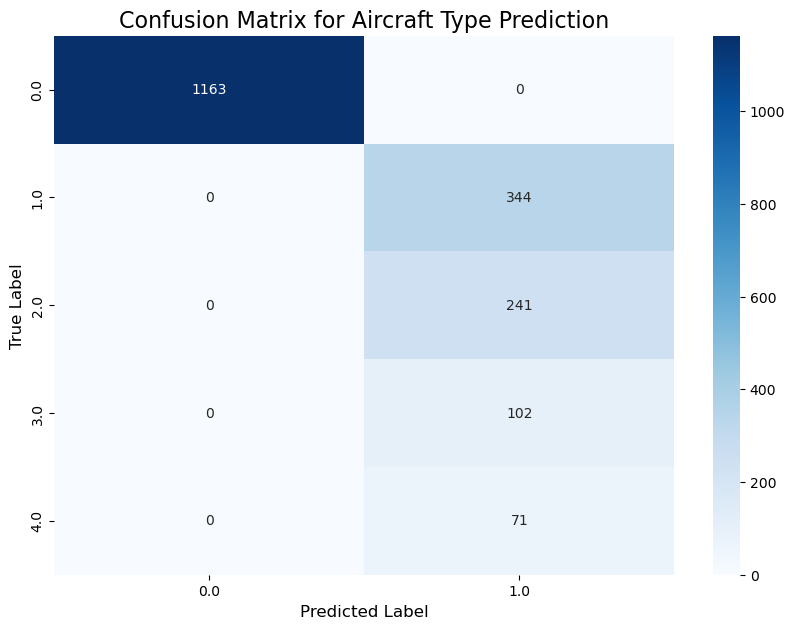

In [5]:
# Run this in your Classification notebook, using the 'lr_predictions' DataFrame

from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

# First, we need to format the confusion matrix data
conf_matrix = lr_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix = conf_matrix.pivot(index='label', columns='prediction', values='count').fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

# Add titles and labels
plt.title('Confusion Matrix for Aircraft Type Prediction', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

In [1]:
# We will use the 'lr_predictions' DataFrame from our Logistic Regression model

from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Prepare the Data ---
# First, we need to get the label names (the actual aircraft types) back for our chart.
# We can get this from the StringIndexer model we created in our pipeline.
label_converter = ml_ready_data.select("AIRCRAFT_TYPE", "label").distinct().toPandas()
label_map = dict(zip(label_converter.label, label_converter.AIRCRAFT_TYPE))

# Next, we format the confusion matrix data from Spark into a Pandas DataFrame suitable for plotting.
conf_matrix_df = lr_predictions.groupBy("label", "prediction").count().toPandas()
conf_matrix_pivot = conf_matrix_df.pivot(index='label', columns='prediction', values='count').fillna(0)

# Rename the index and columns to use the real aircraft names
conf_matrix_pivot = conf_matrix_pivot.rename(index=label_map, columns=label_map)


# --- 2. Create the Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_pivot, 
    annot=True,    # This shows the numbers on the squares
    fmt='g',       # This ensures the numbers are displayed as integers
    cmap='Blues'   # A nice blue color scheme
)

# Add titles and labels
plt.title('Confusion Matrix for Aircraft Type Prediction', fontsize=16)
plt.xlabel('Predicted Aircraft Type', fontsize=12)
plt.ylabel('Actual Aircraft Type', fontsize=12)
plt.show()

NameError: name 'ml_ready_data' is not defined